In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, nsolve

In [7]:
from matplotlib.colors import LogNorm
from matplotlib import rcParams

In [8]:
from wrapper import solve_numeric
from wrapper import EQ1, EQ2, EQ3, EQ4

Define symbols for two codon model

In [9]:
Tt1, Tt2, Tc1, Tc2, Rb1, Rb2, fopt = symbols('Tt1 Tt2 Tc1 Tc2 Rb1 Rb2 fopt')
Rt, Rb, Tt, Tc, N, L, Ksp, Kbd, Kch = symbols('Rt Rb Tt Tc N L Ksp Kbd Kch')

In [12]:
# Pinetree uses this formula to convert some macroscopic rate constants (which are assumed to be derived 
# from macroscopic observations of cellular behavior) to mesoscopic.
# We need to do the same conversion here before running the numeric solver, or else the simulation
# results will not agree with the numeric solutions
def rbs_conversion(rbs):
    AVOGADRO = 6.02214076e23
    VOLUME = 8e-16
    return round(rbs / (AVOGADRO * VOLUME), 10)

This notebook verifies that the numeric solutions of the two-codon system agree with simulations

### Solve system numerically

In [13]:
# Simulation parameters that were used 
RBS_STRENGTH = 10000000.0
kbd = rbs_conversion(RBS_STRENGTH)
params = {N: 100,
       Kbd: kbd,
       Rt: 500,
       Tt1: 1750,
       Tt2: 750,
       Ksp: 2,
       L: 1000}

vals = [30, 100, 300, 1000]
df_numeric = solve_numeric(params, Kch, vals, name="kch") 

{N: 100, Kbd: 0.0207567383, Rt: 500, Tt1: 1750, Tt2: 750, Ksp: 2, L: 1000, Kch: 30}
{N: 100, Kbd: 0.0207567383, Rt: 500, Tt1: 1750, Tt2: 750, Ksp: 2, L: 1000, Kch: 100}
{N: 100, Kbd: 0.0207567383, Rt: 500, Tt1: 1750, Tt2: 750, Ksp: 2, L: 1000, Kch: 300}
{N: 100, Kbd: 0.0207567383, Rt: 500, Tt1: 1750, Tt2: 750, Ksp: 2, L: 1000, Kch: 1000}


In [14]:
df_numeric["protein_expr_rate"] = df_numeric["protein"] / 100

In [15]:
# read in simulation data
df_sim = pd.read_csv("single_codon_protein_prod_05_07_09_speed_2.csv") # this should be "two codon" but I accidentally misnamed it when I ran these originally
df_sim = df_sim[df_sim["charging_rate"].isin([30, 100, 300, 1000])]
df_sim["fraction_pref_trna"] = df_sim["skew"]
df_sim = df_sim[(df_sim.fraction_pref_trna == 0.7) & (df_sim.species == "cellularProtein")]

In [16]:
df_sim["protein_expr_rate"] = df_sim["protein"] / 100

In [17]:
fops = [i/100 for i in range(3, 100, 4)]

In [18]:
# filter out missing data so that point spacing is consistent for each curve
df_sim_filtered = df_sim[df_sim["codon"].isin(fops)]

Text(0, 0.5, 'simulated protein')

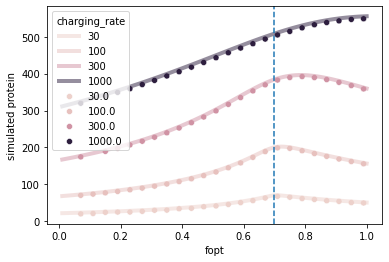

In [19]:
sns.lineplot(data=df_numeric, 
                 x="fopt", 
                 y="protein_expr_rate", 
                 hue="kch", 
                 linewidth=4,
                 alpha=0.5
                 )

g = sns.scatterplot(data=df_sim_filtered, x="codon", y="protein_expr_rate", hue="charging_rate")

plt.axvline(0.7, ls='--')
g.set_ylabel("simulated protein")

In [20]:
df_sim_filtered["fopt"] = df_sim_filtered["codon"]
df_sim_filtered["kch"] = df_sim_filtered["charging_rate"]
df_1 = df_sim_filtered[["fopt", "protein", "protein_expr_rate", "kch"]].reset_index(drop=True)
df_1["type"] = "simulation"

/tmp/ipykernel_1064648/3360155500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim_filtered["fopt"] = df_sim_filtered["codon"]
/tmp/ipykernel_1064648/3360155500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sim_filtered["kch"] = df_sim_filtered["charging_rate"]


In [21]:
df_2 = df_numeric[["fopt", "protein", "protein_expr_rate", "kch"]].reset_index(drop=True)
df_2["type"] = "numeric"

In [22]:
# concat sim and numeric data into single dataframe
df_master = pd.concat([df_1, df_2])

In [91]:
#df_master.to_csv("verify_numeric.csv")

Found a more complete dataset to do this with. Here we actually have steady-state simulation data which might yeild even better agreement

In [24]:
df_sim_last100 = pd.read_csv("single_codon_protein_prod_05_07_09_speed_2_last_100.csv")

In [25]:
df_sim_last100 = df_sim_last100[df_sim_last100["charging_rate"].isin([30, 100, 300, 1000])]
df_sim_last100["fraction_pref_trna"] = df_sim_last100["skew"]
df_sim_last100 = df_sim_last100[(df_sim_last100.fraction_pref_trna == 0.7) & (df_sim_last100.species == "cellularProtein")]

In [26]:
tmp = df_sim_last100[(df_sim_last100.time == 100) | (df_sim_last100.time == 200)]
tmp["fopt"] = tmp["codon"]
tmp["kch"] = tmp["charging_rate"]

/tmp/ipykernel_1064648/1444623817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["fopt"] = tmp["codon"]
/tmp/ipykernel_1064648/1444623817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["kch"] = tmp["charging_rate"]


In [27]:
tmp = tmp[["fopt", "time", "protein", "kch"]].reset_index(drop=True)

In [28]:
# we'll process this further in R because its easier
tmp.to_csv("verify_numeric_sim_ss.csv")